In [1]:
import cantera as ct
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True
import os
import glob
import itertools
from random import randint
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path
import time

import matplotlib.cm as cm
from IPython.display import Image
import git

from rmgpy.molecule import Molecule
from rmgpy.data.base import Database

In [2]:
surf = ct.Solution('/work/westgroup/lee.ting/cantera/ammonia/base/cantera/chem_annotated.cti')

In [3]:
ct.suppress_thermo_warnings()

<IPython.core.display.Javascript object>


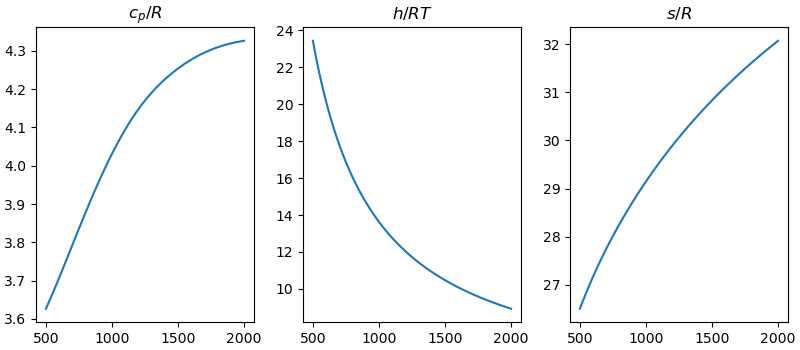

In [8]:
sp = surf.species('NO(5)')
T = np.linspace(500, 2000, 100)
f,ax = plt.subplots(1,3, figsize=(8,3.5))

def plot_thermo(thermo):
    h = [thermo.h(tt)/(ct.gas_constant * tt) for tt in T]
    cp = [thermo.cp(tt)/ct.gas_constant for tt in T]
    s = [thermo.s(tt)/ct.gas_constant for tt in T]
    ax[0].plot(T,cp)
    ax[0].set_title('$c_p/R$')
    ax[1].plot(T,h)
    ax[1].set_title('$h/RT$')
    ax[2].plot(T,s)
    ax[2].set_title('$s/R$')
plot_thermo(sp.thermo)

In [5]:
c0 = sp.thermo.coeffs
c0

array([ 1.40702000e+03,  2.93798085e+00,  1.75424119e-03, -7.77004101e-07,
        1.42651639e-10, -9.57838144e-15,  1.00390907e+04,  7.44011605e+00,
        3.55718148e+00, -8.90571060e-04,  2.98553150e-06, -2.08687561e-09,
        4.65949875e-13,  9.95239684e+03,  4.55251498e+00])

In [6]:
c0[0] = 700
test = ct.NasaPoly2(sp.thermo.min_temp, sp.thermo.max_temp, sp.thermo.reference_pressure, c0)
plot_thermo(test)

In [49]:
c0[0] = 1000
test = ct.NasaPoly2(sp.thermo.min_temp, sp.thermo.max_temp, sp.thermo.reference_pressure, c0)
plot_thermo(test)

In [10]:
surf.TPX = 2000, 101325, 'NH3(6):0.06, O2(2):0.88'
surf.equilibrate('TP')
surf()


  gas:

       temperature            2000  K
          pressure          101325  Pa
           density        0.186037  kg/m^3
  mean mol. weight         30.5313  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      1.2446e+06          3.8e+07     J
   internal energy      6.9993e+05        2.137e+07     J
           entropy            8895        2.716e+05     J/K
    Gibbs function     -1.6545e+07       -5.052e+08     J
 heat capacity c_p          1253.1        3.826e+04     J/K
 heat capacity c_v          980.74        2.994e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
             O2(2)       0.872112          0.91403         -28.8997
            H2O(3)      0.0925645        0.0546185         -44.3349
             N2(4)      0.0306554        0.0281273         -30.4257
             NO(5)      0.00

<IPython.core.display.Javascript object>


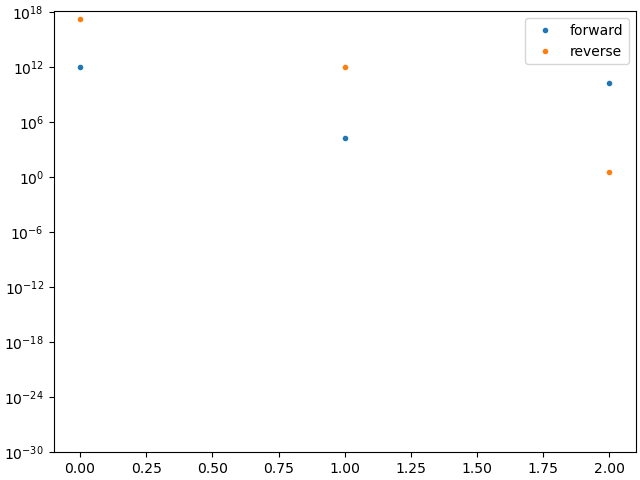

In [9]:
f, ax = plt.subplots()
ax.semilogy(surf.forward_rate_constants, '.', label='forward')
ax.semilogy(surf.reverse_rate_constants, '.', label='reverse')
ax.axis(ymin=1e-30)
ax.legend();

In [69]:
kr = surf.reverse_rate_constants
for i, k in enumerate(kr):
    if k > 1e20:
        print(f'{i:4d}  {k:.4e}  {surf.reaction_equation(i)}')

In [70]:
gri = ct.Solution('gri30.cti')
for i, r in enumerate(gri.reactions()):
    if 'N2' in r and 'O2' in r and 'CH' in r:
        print(i, r)

/home/lee.ting/.conda/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


<IPython.core.display.Javascript object>


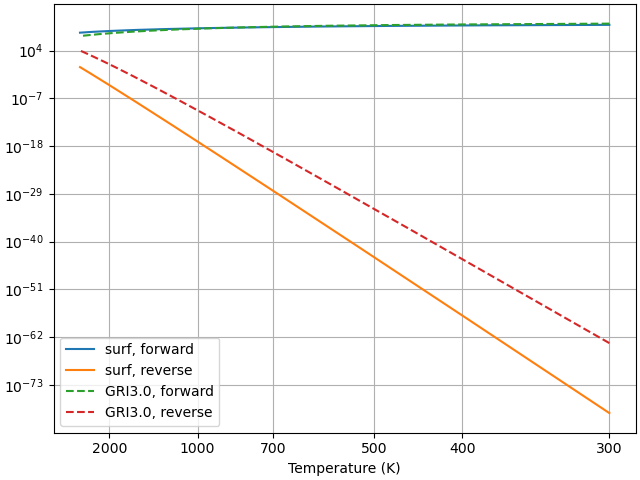

In [71]:
surfN = ct.SolutionArray(surf, shape=200)
griN = ct.SolutionArray(gri, shape=200)
T = np.linspace(300, 3000, 200)
surfN.TPY = T, ct.one_atm, 'NH3(6):0.066, O2(2):0.88'
griN.TPY = T, ct.one_atm, 'NH3:0.066, O2:0.88'

f,ax = plt.subplots()
ax.semilogy(1000/T, surfN.forward_rate_constants[:,0], label='surf, forward')
ax.semilogy(1000/T, surfN.reverse_rate_constants[:,0], label='surf, reverse')
ax.semilogy(1000/T, griN.forward_rate_constants[:,288], '--', label='GRI3.0, forward')
ax.semilogy(1000/T, griN.reverse_rate_constants[:,288], '--', label='GRI3.0, reverse')
T_label = np.array([300, 400, 500, 700, 1000, 2000])
ax.set(xticks=1000/T_label, xticklabels=T_label, xlabel='Temperature (K)')
ax.legend()
ax.grid(True)